Expected Shift: 0.2000 nm
Measured Shift from Cross-Correlation: 0.2001 nm


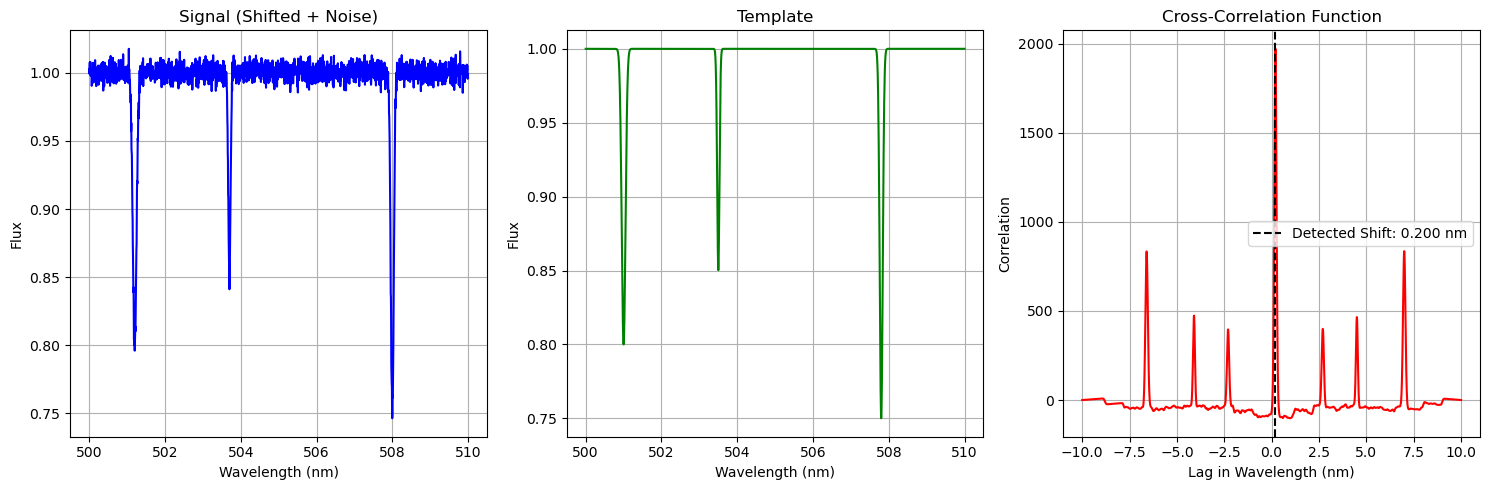

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define Gaussian absorption line function
def gaussian(x, center, amplitude, sigma):
    return amplitude * np.exp(-0.5 * ((x - center) / sigma)**2)

# Create a basic spectrum with Gaussian absorption lines
def make_spectrum(wave, line_centers, line_amplitudes, line_sigmas):
    flux = np.ones_like(wave)  # Start with a flat line
    for c, a, s in zip(line_centers, line_amplitudes, line_sigmas):
        
        flux -= gaussian(wave, center=c, amplitude=a, sigma=s)  # Add absorption lines
    return flux

# Shift spectrum in wavelength space using interpolation
def shift_spectrum(wave, flux, shift):
    shifted_wave = wave + shift
    return np.interp(wave, shifted_wave, flux, left=flux[0], right=flux[-1])


wave = np.linspace(500.0, 510.0, 2000)  # Wavelength range from 500 to 510 nm

# Define absorption line parameters
line_centers = [501.0, 503.5, 507.8]   # nm (absorption line positions)
line_amplitudes = [0.20, 0.15, 0.25]   # Depth of each line
line_sigmas = [0.05, 0.03, 0.04]       # Width of each Gaussian line

# Generate the template spectrum
template_flux = make_spectrum(wave, line_centers, line_amplitudes, line_sigmas)

# Apply Doppler shift to create the observed signal
shift_amount = 0.2  # Shift in nm
signal_flux = shift_spectrum(wave, template_flux, shift=shift_amount)

# Add a small amount of noise to the signal
np.random.seed(42)
noise_level = 0.005
signal_flux += noise_level * np.random.randn(len(signal_flux))

# Perform cross-correlation
# Normalize both spectra by subtracting the mean and dividing by their standard deviation
template_flux_norm = (template_flux - np.mean(template_flux)) / np.std(template_flux)
signal_flux_norm = (signal_flux - np.mean(signal_flux)) / np.std(signal_flux)

# Compute cross-correlation with 'valid' mode to avoid edge effects
ccf = np.correlate(signal_flux_norm, template_flux_norm, mode='full')

# Create array of lags (converted to wavelength shift)
lags = np.arange(- (len(template_flux) - 1), len(signal_flux))
delta_lambda = wave[1] - wave[0]  # nm per pixel (approx)
wavelength_lags = lags * delta_lambda

# Find the peak of the cross-correlation to determine the measured shift
peak_index = np.argmax(ccf)  # Index of max correlation
measured_shift = wavelength_lags[peak_index]  # Convert to wavelength units

# Print detected shift
print(f"Expected Shift: {shift_amount:.4f} nm")
print(f"Measured Shift from Cross-Correlation: {measured_shift:.4f} nm")

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot signal spectrum
axes[0].plot(wave, signal_flux, color='blue')
axes[0].set_title("Signal (Shifted + Noise)")
axes[0].set_xlabel("Wavelength (nm)")
axes[0].set_ylabel("Flux")
axes[0].grid(True)

# Plot template spectrum
axes[1].plot(wave, template_flux, color='green')
axes[1].set_title("Template")
axes[1].set_xlabel("Wavelength (nm)")
axes[1].set_ylabel("Flux")
axes[1].grid(True)

# Plot cross-correlation function
axes[2].plot(wavelength_lags, ccf, color='red')
axes[2].set_title("Cross-Correlation Function")
axes[2].set_xlabel("Lag in Wavelength (nm)")
axes[2].set_ylabel("Correlation")
axes[2].axvline(measured_shift, color='black', linestyle='dashed', label=f"Detected Shift: {measured_shift:.3f} nm")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()
